In [5]:
%matplotlib inline


import os
import json
import matplotlib.pyplot as plt
import numpy as np
import ants
import SimpleITK as sitk
import nibabel as nib

print(f'AntsPy version = {ants.__version__}')
print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.5.3
SimpleITK version = 2.3.1


In [27]:
def load_data(jsonData, dataFolderPath, filterString='0001'):
    training_paths = []
    for i in range(len(jsonData['training_paired_images'])):
        tmproot, tmpext = os.path.splitext(jsonData['training_paired_images'][i]['moving'])
        root, ext = os.path.splitext(tmproot)
        splitRoot = root.split('_')
        if splitRoot[-1] == filterString:
            training_paths.append(jsonData['training_paired_images'][i])

    fixedData = []
    movingData = []
    for image in training_paths:
        fixedImg = np.squeeze(nib.load(dataFolderPath + image['fixed'].removeprefix('.')).get_fdata())
        antsFixed = ants.from_numpy(fixedImg)
        fixedData.append(antsFixed)
        movingImg = nib.load(dataFolderPath + image['moving'].removeprefix('.')).get_fdata()
        movingImg_reshaped = rgb_to_grayscale(
            movingImg.reshape(jsonData['tensorImageShape'][0]['0'][0], jsonData['tensorImageShape'][0]['0'][1],
                              3).astype(np.uint8))
        antsMoving = ants.from_numpy(movingImg_reshaped)
        movingData.append(antsMoving)

    return fixedData, movingData


def rgb_to_grayscale(image):
    # Extract RGB components
    red_channel = image[:, :, 0]  # Red channel
    green_channel = image[:, :, 1]  # Green channel
    blue_channel = image[:, :, 2]  # Blue channel

    # Convert to grayscale using the luminance formula
    grayscale_image = red_channel * 0.2989 + green_channel * 0.5870 + blue_channel * 0.1140

    return grayscale_image

In [28]:
# load data
with open('./data/COMULISSHGBF/COMULISSHGBF_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './data/COMULISSHGBF'
data_fixed_raw, data_moved_raw = load_data(data_json, dataFolder)

(-0.5, 833.5, 833.5, -0.5)

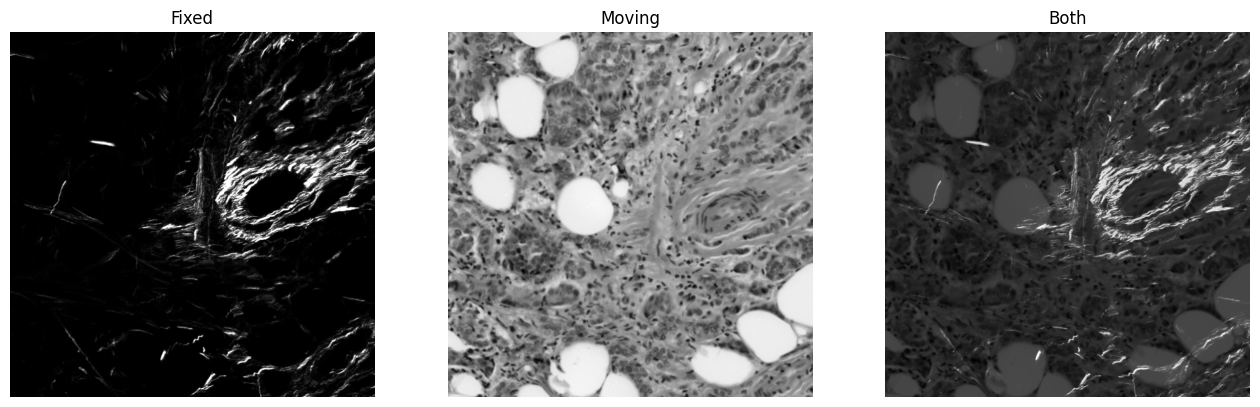

In [78]:
# preview data
img = 25

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 8))
ax0.imshow(data_fixed_raw[img].numpy(), cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(data_moved_raw[img].numpy(), cmap='gray')
ax1.set_title("Moving")
ax1.axis("off")
ax2.imshow(data_fixed_raw[img].numpy(), cmap='gray')
ax2.imshow(data_moved_raw[img].numpy(), alpha=0.3, cmap='gray')
ax2.set_title("Both")
ax2.axis("off")

In [79]:
print(data_fixed_raw[img].shape)
print(data_moved_raw[img].shape)

(834, 834)
(834, 834)


In [80]:
transformation = ants.registration(
    fixed=data_fixed_raw[img],
    moving=data_moved_raw[img],
    type_of_transform='SyNRA',
    aff_metric='mattes',
    aff_sampling=32,
    verbose=True
)

antsRegistration -d 2 -r [000001FE81B958E8,000001FE88767868,1] -m mattes[000001FE81B958E8,000001FE88767868,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[000001FE81B958E8,000001FE88767868,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[000001FE81B958E8,000001FE88767868,1,32] -t SyN[0.200000,3.000000,0.000000] -c [40x20x0,1e-7,8] -s 2x1x0 -f 4x2x1 -u 1 -z 1 -o [C:\Users\Tilmann\AppData\Local\Temp\tmp1r9_29rj,000001FE81B95D68,000001FE81B961C8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1


In [81]:
print(transformation)

{'warpedmovout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (834, 834)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'warpedfixout': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (834, 834)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'fwdtransforms': ['C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp1r9_29rj1Warp.nii.gz', 'C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp1r9_29rj0GenericAffine.mat'], 'invtransforms': ['C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp1r9_29rj0GenericAffine.mat', 'C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp1r9_29rj1InverseWarp.nii.gz']}


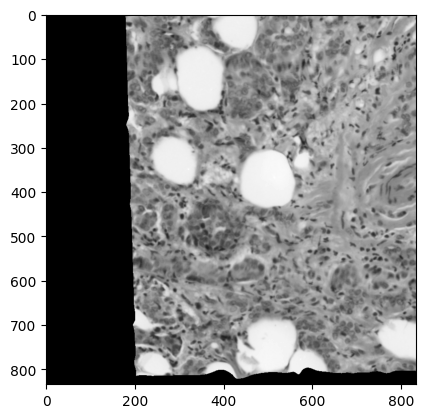

In [82]:
registered_img_ants = transformation['warpedmovout']

plt.imshow(registered_img_ants.numpy(), cmap='gray')

(-0.5, 833.5, 833.5, -0.5)

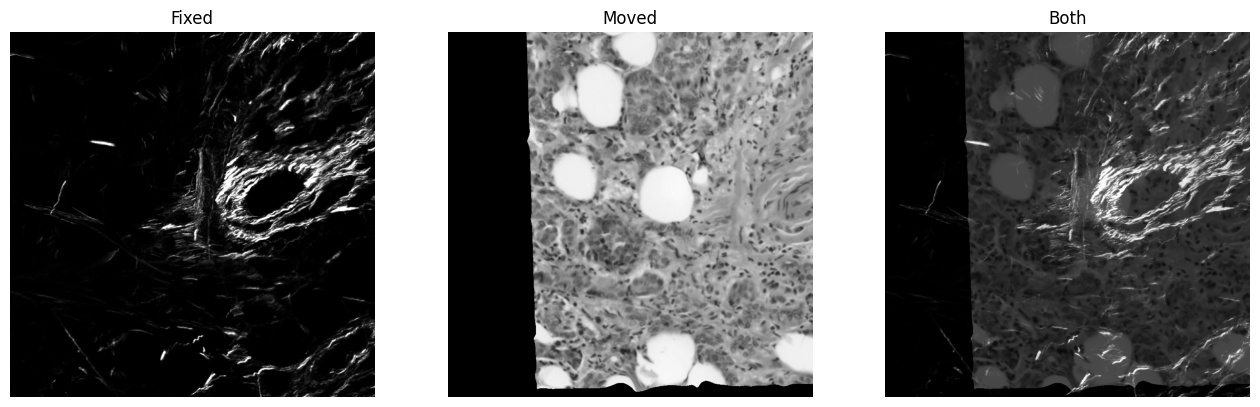

In [83]:
# preview data

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 8))
ax0.imshow(data_fixed_raw[img].numpy(), cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(registered_img_ants.numpy(), cmap='gray')
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(data_fixed_raw[img].numpy(), cmap='gray')
ax2.imshow(registered_img_ants.numpy(), alpha=0.3, cmap='gray')
ax2.set_title("Both")
ax2.axis("off")

Mir fällt gerade auf, dass es eigentlich keinen Sinn macht auf diesem Datenset Deformable Image Registration zu machen, da die meistens einfach nur eine Rotation und verschiebung sind und keine verzerrung.........
